In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
d = '../src/scripts'

import sys
if not d in sys.path:
    sys.path.append(d)

In [3]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck18
import astropy.units as u
import dataclasses
from dataclasses import dataclass
from glob import glob
import h5py
import intensity_models
from intensity_models import make_pop_model, make_pop_cosmo_model
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import re
import scipy.stats as ss
import seaborn as sns
import time
from tqdm.notebook import tqdm
from utils import pt_interp, pt_cumtrapz
import weighting

sns.set_theme('notebook', 'ticks', 'colorblind')

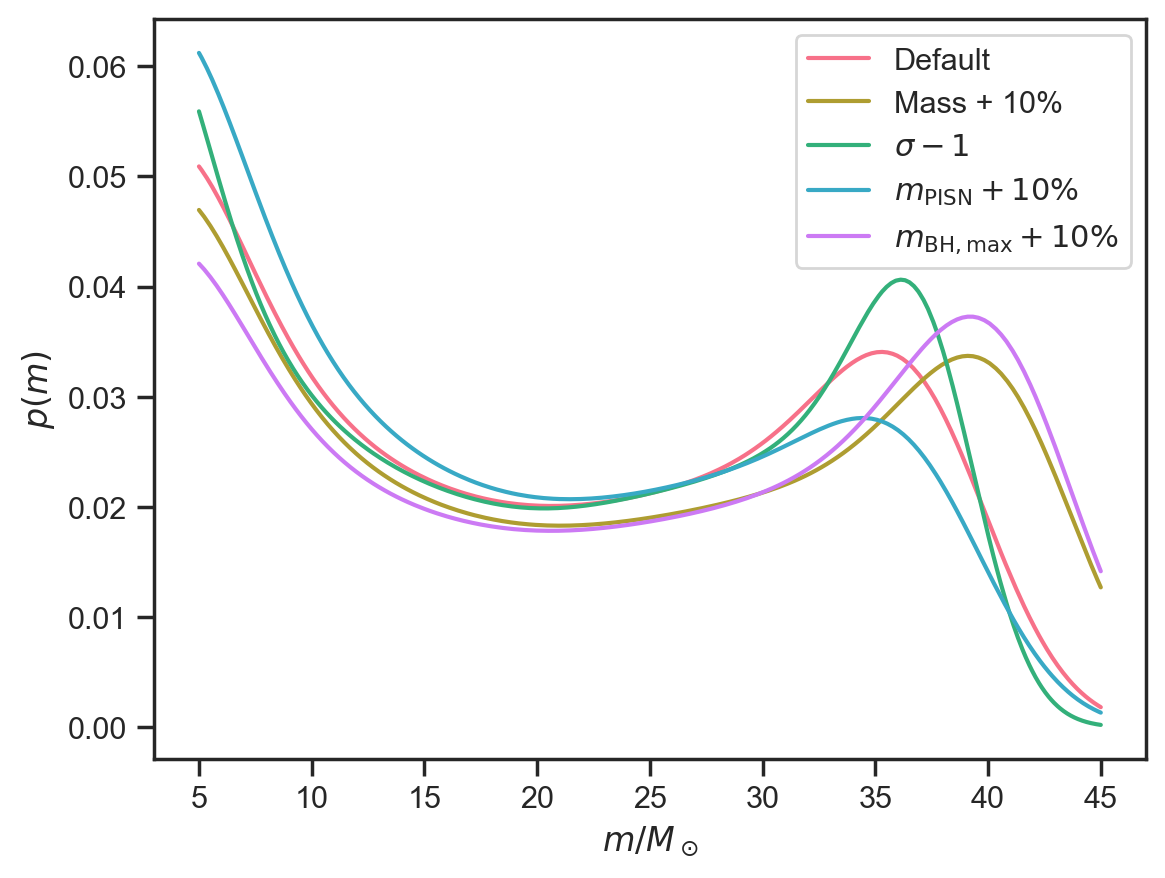

In [4]:
a, b, mpisn, mbhmax, sigma = weighting.a, weighting.b, weighting.mpisn, weighting.mbhmax, weighting.sigma

with sns.color_palette('husl', n_colors=5):
    m = np.linspace(5, 45, 1024)
    def plot_mass_model(dndm, label=None):
        dndm = dndm / np.trapz(dndm, m)
        plt.plot(m, dndm, label=label)
    plot_mass_model(np.exp(intensity_models.LogDNDMPISN(a, b, mpisn, mbhmax, sigma)(m).eval()), label='Default')
    plot_mass_model(np.exp(intensity_models.LogDNDMPISN(a, b, mpisn*1.1, mbhmax*1.1, sigma)(m).eval()), label='Mass + 10%')
    plot_mass_model(np.exp(intensity_models.LogDNDMPISN(a, b, mpisn, mbhmax, sigma-1)(m).eval()), label=r'$\sigma - 1$')
    plot_mass_model(np.exp(intensity_models.LogDNDMPISN(a, b, mpisn*1.1, mbhmax, sigma)(m).eval()), label=r'$m_\mathrm{PISN} + 10\%$')
    plot_mass_model(np.exp(intensity_models.LogDNDMPISN(a, b, mpisn, mbhmax*1.1, sigma)(m).eval()), label=r'$m_\mathrm{BH,max} + 10\%$')
    plt.legend()
    plt.xlabel(r'$m / M_\odot$')
    plt.ylabel(r'$p(m)$')

In [5]:
pe_samples = pd.read_hdf('../src/data/pe-samples.h5', key='samples')
m1s = []
qs = []
zs = []
for (n, e) in pe_samples.groupby('evt'):
    m1s.append(e['m1'])
    qs.append(e['q'])
    zs.append(e['z'])
m1s, qs, zs = map(np.array, [m1s, qs, zs])

Text(0, 0.5, '$m_2 / M_\\odot$')

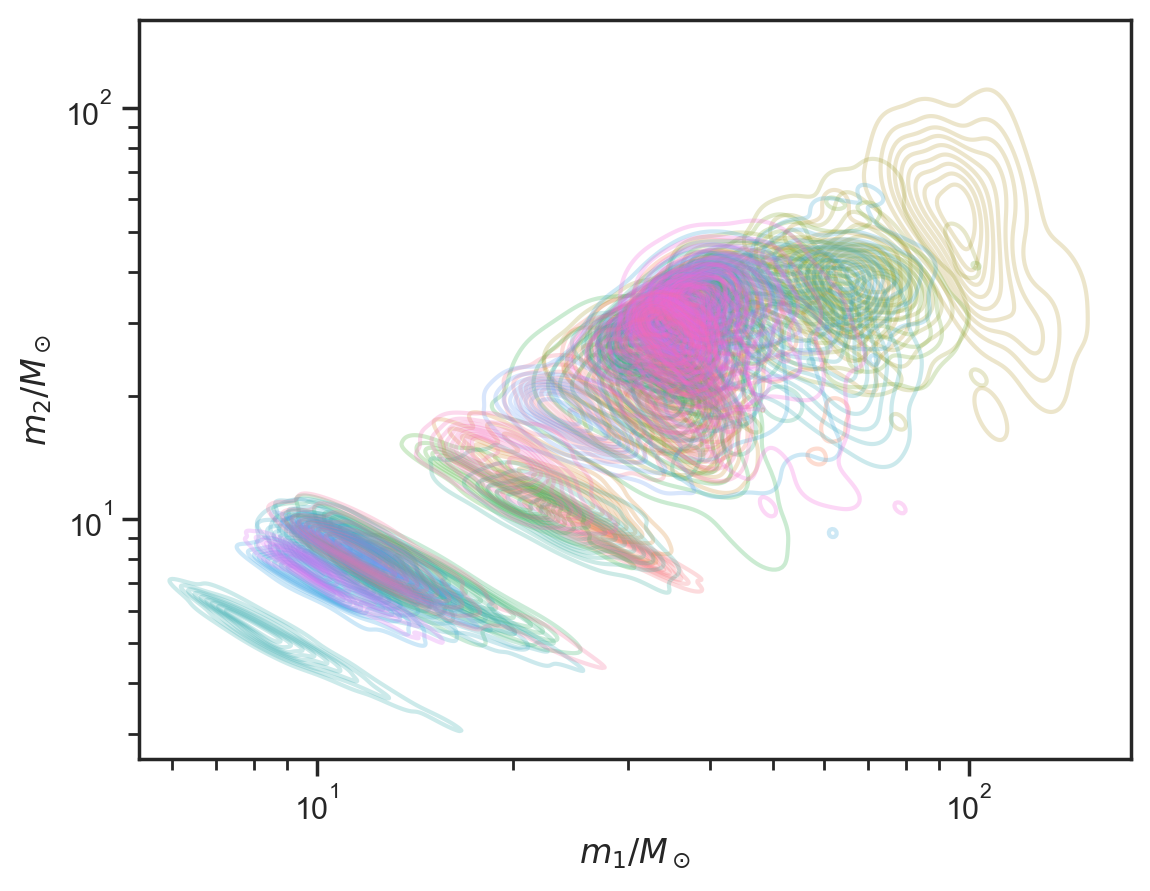

In [6]:
with sns.color_palette('husl', n_colors=m1s.shape[0]):
    for i in range(m1s.shape[0]):
        sns.kdeplot(x=m1s[i,:], y=qs[i,:]*m1s[i,:], log_scale=True, alpha=0.25)
plt.xlabel(r'$m_1 / M_\odot$')
plt.ylabel(r'$m_2 / M_\odot$')

Text(0, 0.5, '$m_1 / M_\\odot$')

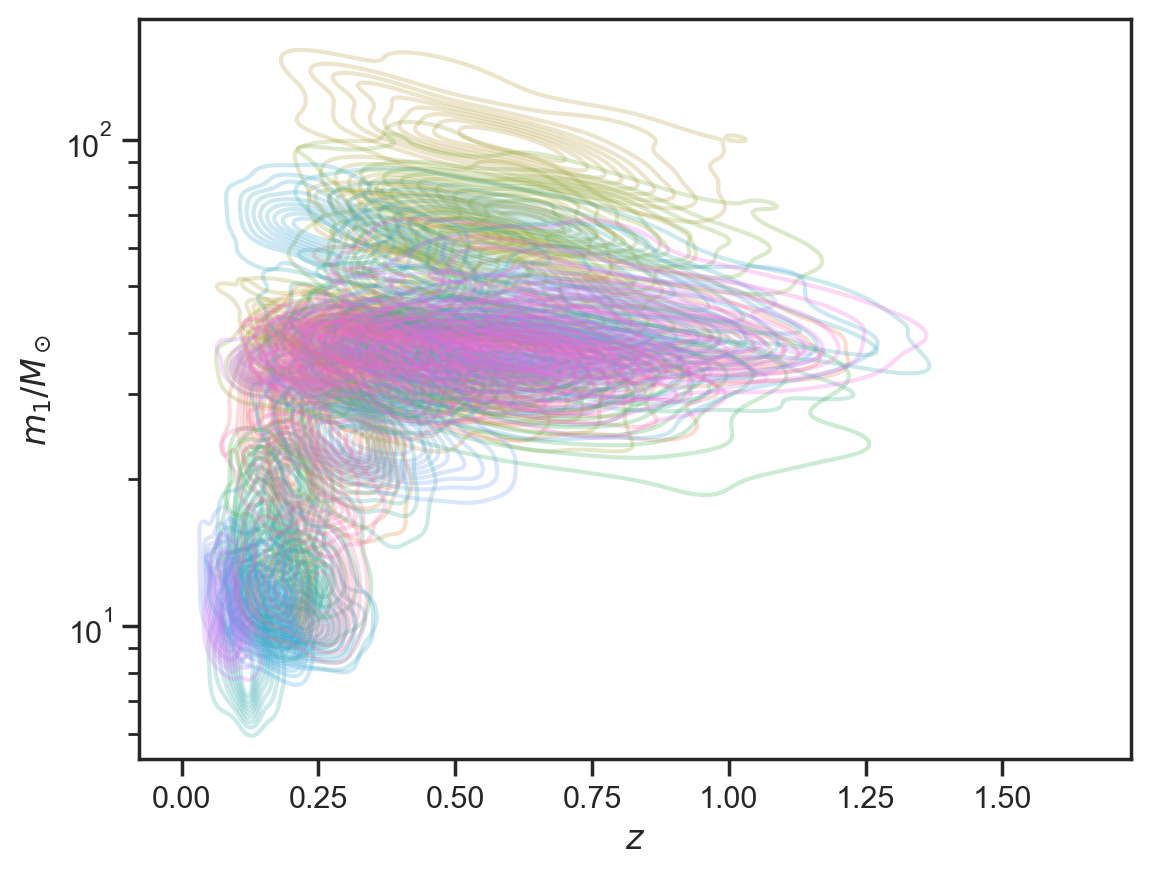

In [7]:
with sns.color_palette('husl', n_colors=m1s.shape[0]):
    for i in range(m1s.shape[0]):
        sns.kdeplot(x=zs[i,:], y=m1s[i,:], log_scale=(False, True), alpha=0.25)
plt.xlabel(r'$z$')
plt.ylabel(r'$m_1 / M_\odot$')

In [28]:
trace = az.from_netcdf('../src/data/trace.nc')

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>],
       [<Axes: title={'center': 'mpisn'}>,
        <Axes: title={'center': 'mpisn'}>],
       [<Axes: title={'center': 'mbhmax'}>,
        <Axes: title={'center': 'mbhmax'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'fpl'}>, <Axes: title={'center': 'fpl'}>],
       [<Axes: title={'center': 'lam'}>, <Axes: title={'center': 'lam'}>],
       [<Axes: title={'center': 'kappa'}>,
        <Axes: title={'center': 'kappa'}>],
       [<Axes: title={'center': 'zp'}>, <Axes: title={'center': 'zp'}>]],
      dtype=object)

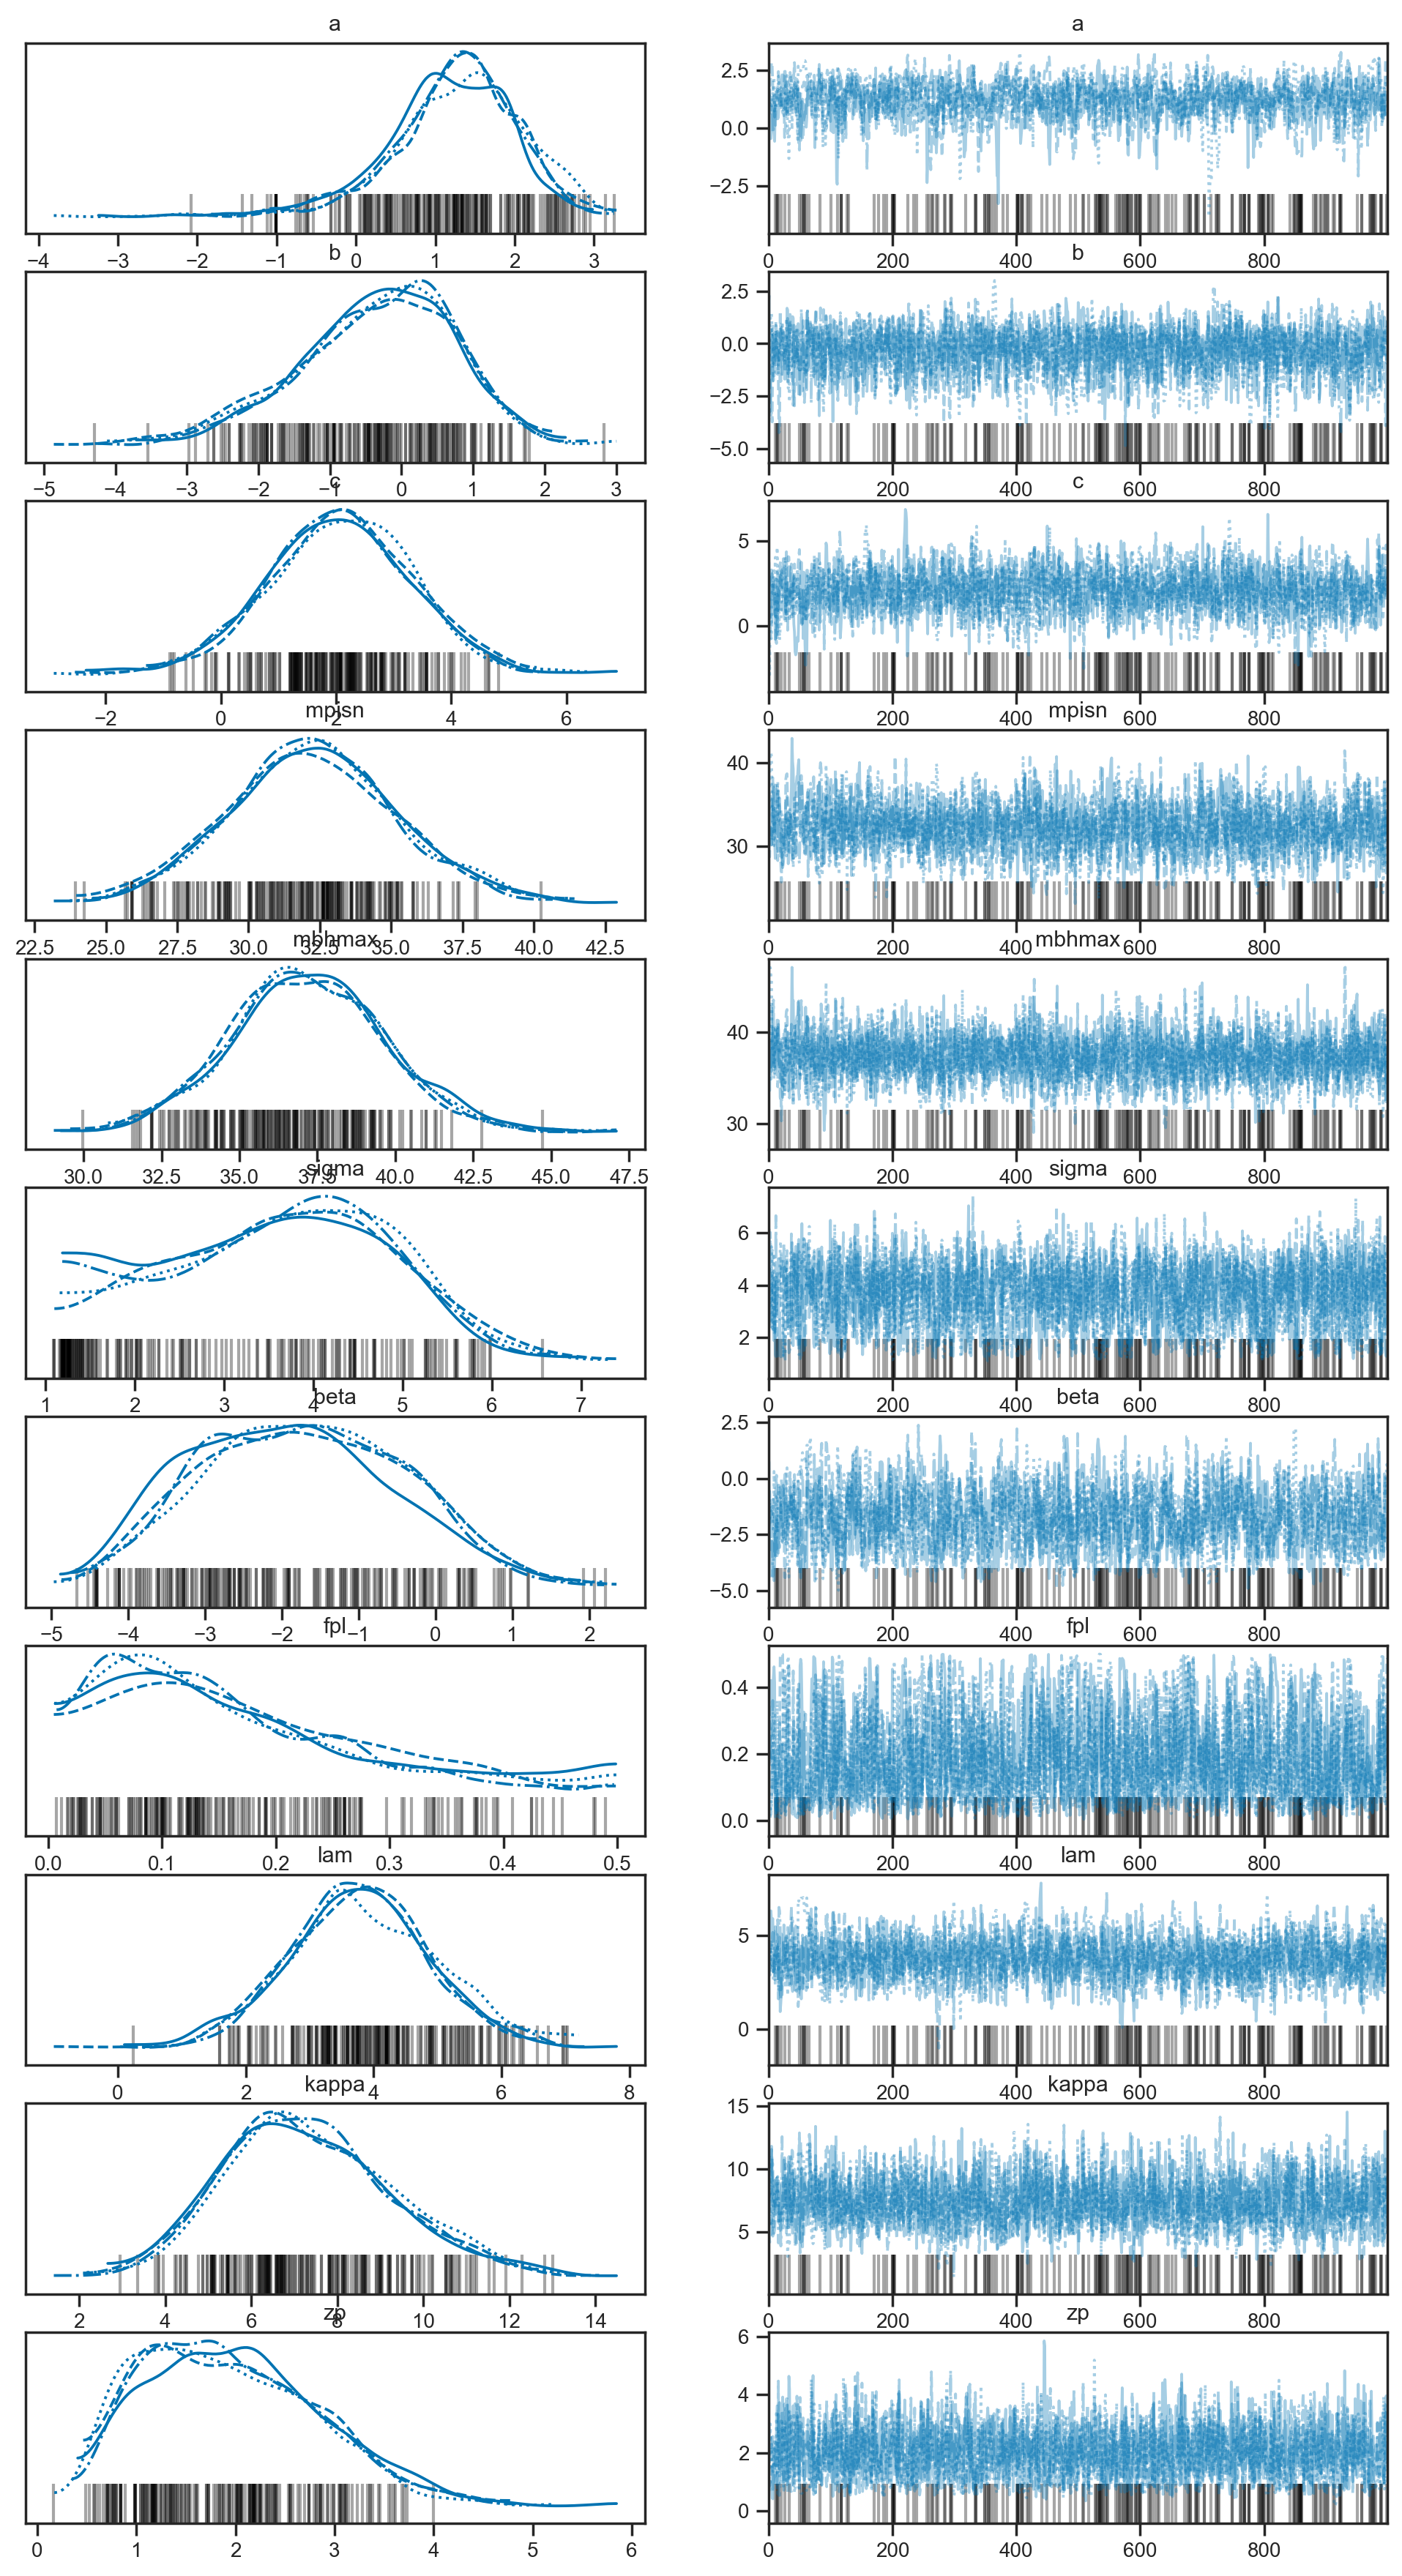

In [29]:
az.plot_trace(trace, var_names=['a', 'b', 'c', 'mpisn', 'mbhmax', 'sigma', 'beta', 'fpl', 'lam', 'kappa', 'zp'])

In [30]:
trace.posterior.neff.min(dim=['chain', 'draw'])

<xarray.DataArray 'neff' (obs: 56)>
array([155.04242398, 211.81407537, 151.7800791 ,  84.98802445,
        49.83178594, 106.0817082 , 162.77654582, 138.57612932,
       126.21284851,  26.11643521,  58.25337329, 104.40006336,
       119.90410309,  47.04170393,  83.23249353, 140.62076741,
        72.3575993 ,   9.72365769, 242.74665886, 198.0525751 ,
        95.53722691, 221.58181012, 108.96001002, 217.20248346,
        97.61750374, 118.62435142, 168.5632368 , 172.94704493,
        70.29501718, 166.01641895, 242.05664031,  69.65625077,
       227.84019602, 224.24286136, 242.55956871,  24.68060447,
        24.81148251, 241.8912572 , 241.9797781 , 114.50217275,
       213.78203348,  81.02901646,  63.48945951, 150.06445548,
        87.6780849 ,  92.0338029 , 247.3658946 , 112.51254401,
       128.41621021,  59.45403165, 122.4328927 , 108.58962332,
       165.4745035 , 127.25322982, 157.80393216, 188.77474515])
Coordinates:
  * obs      (obs) int64 0 1 2 3 4 5 6 7 8 9 ... 46 47 48 49 50 51 52 53 54 55

In [31]:
trace.posterior.neff.min()

<xarray.DataArray 'neff' ()>
array(9.72365769)

In [32]:
trace.posterior.neff_sel.min()

<xarray.DataArray 'neff_sel' ()>
array(616.37367681)

In [21]:
trace_cosmo = az.from_netcdf('../src/data/trace_cosmo.nc')

array([[<Axes: title={'center': 'h'}>, <Axes: title={'center': 'h'}>],
       [<Axes: title={'center': 'Om'}>, <Axes: title={'center': 'Om'}>],
       [<Axes: title={'center': 'w'}>, <Axes: title={'center': 'w'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>],
       [<Axes: title={'center': 'mpisn'}>,
        <Axes: title={'center': 'mpisn'}>],
       [<Axes: title={'center': 'mbhmax'}>,
        <Axes: title={'center': 'mbhmax'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'fpl'}>, <Axes: title={'center': 'fpl'}>],
       [<Axes: title={'center': 'lam'}>, <Axes: title={'center': 'lam'}>],
       [<Axes: title={'center': 'kappa'}>,
        <Axes: title={'center':

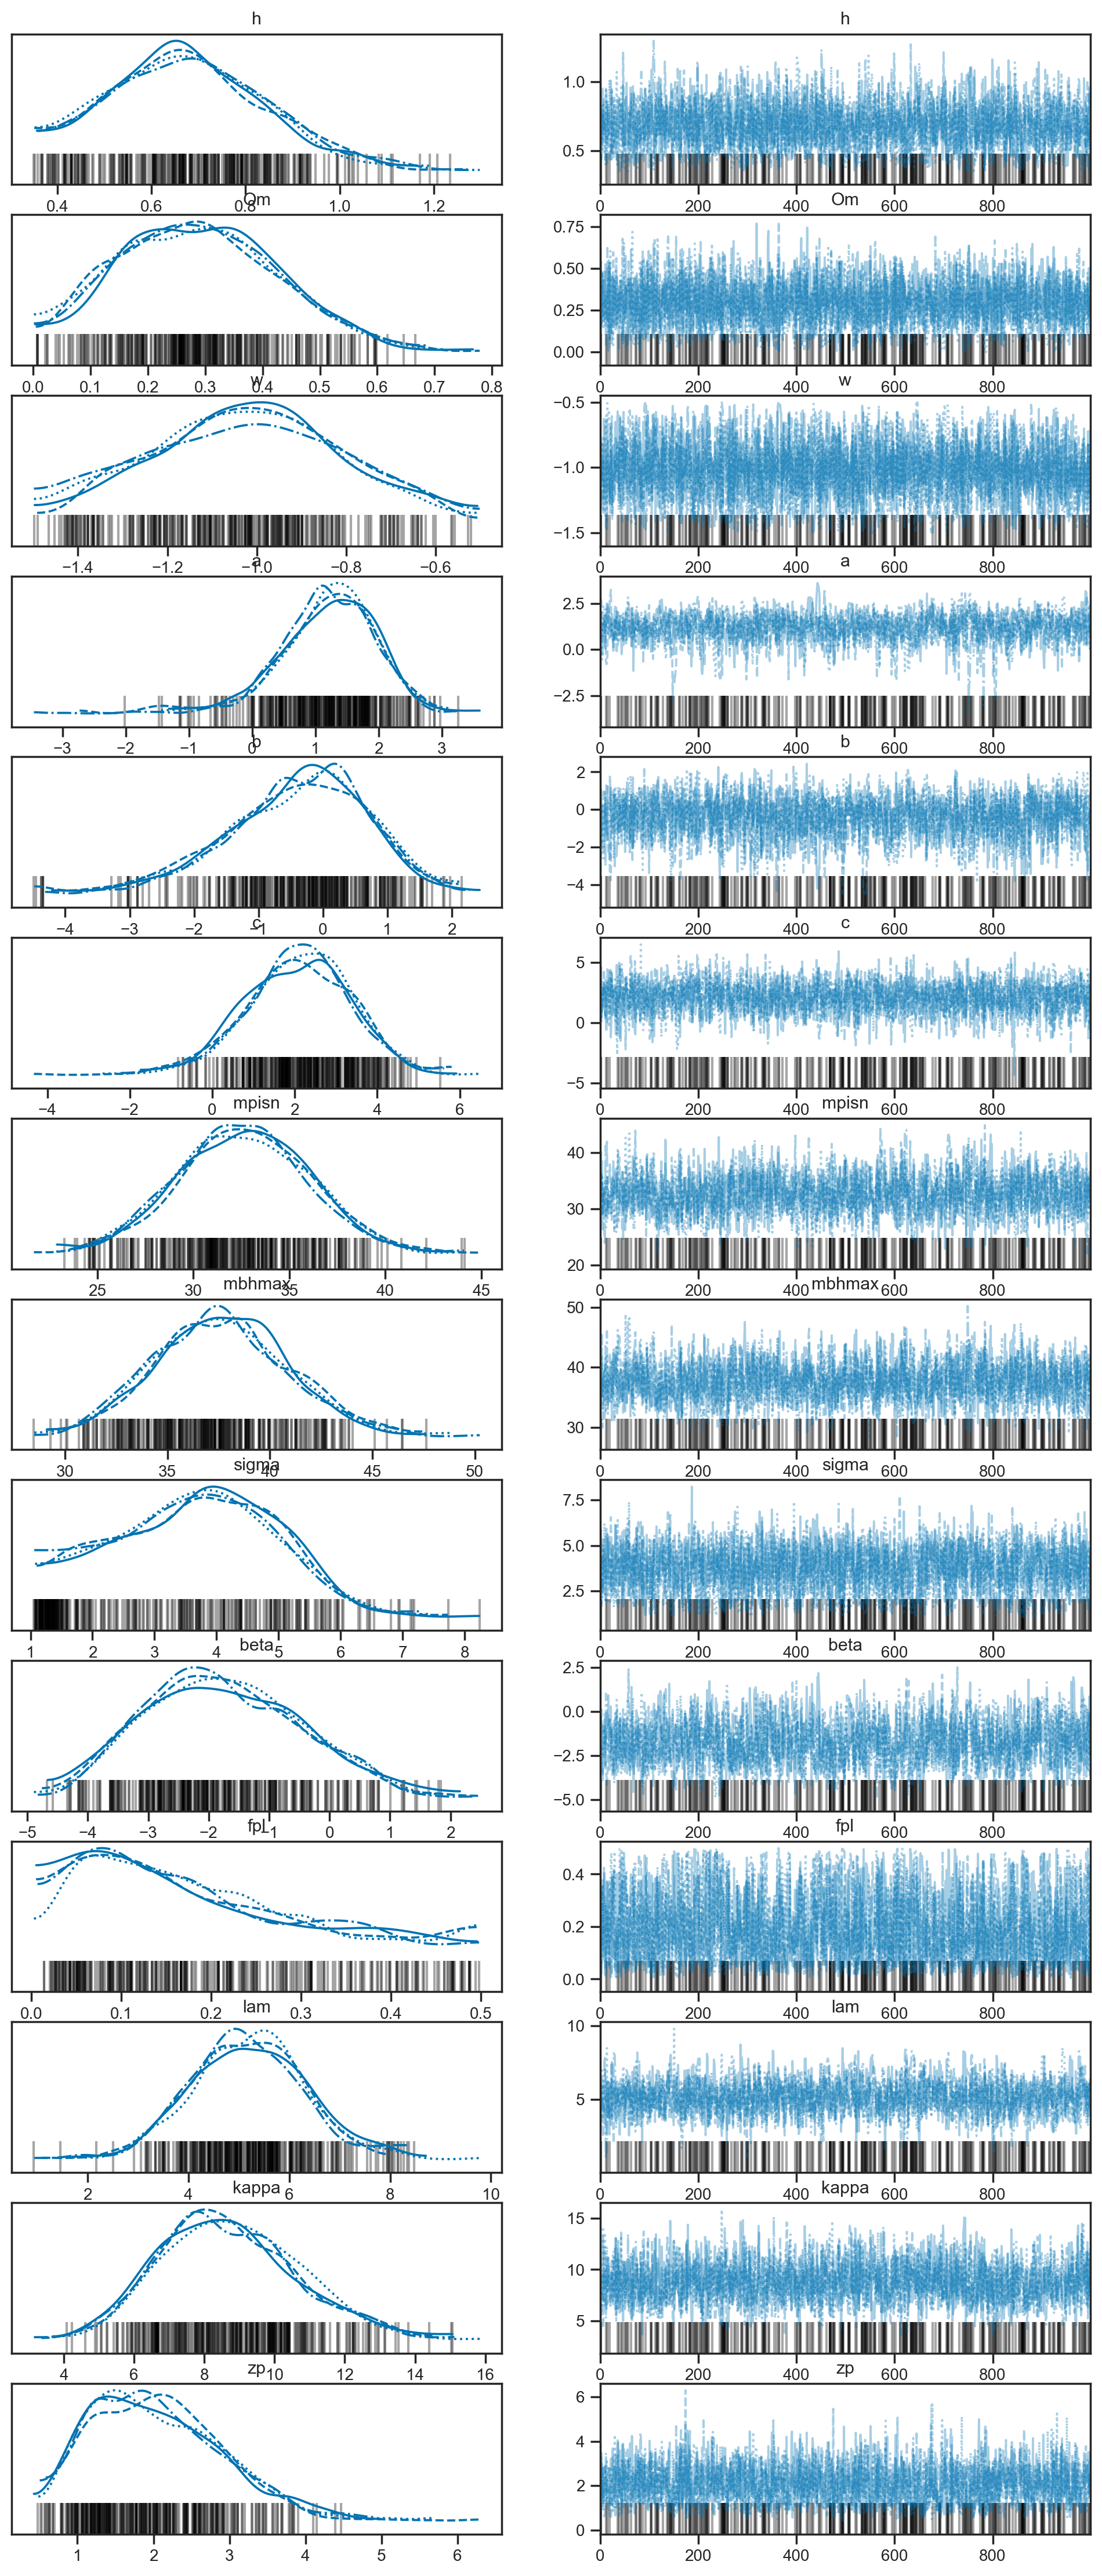

In [22]:
az.plot_trace(trace_cosmo, var_names=['h', 'Om', 'w', 'a', 'b', 'c', 'mpisn', 'mbhmax', 'sigma', 'beta', 'fpl', 'lam', 'kappa', 'zp'])

In [23]:
trace_cosmo.posterior.neff.min(dim=['chain', 'draw'])

<xarray.DataArray 'neff' (obs: 56)>
array([170.77781196, 207.57364126, 145.56301228,  90.30365764,
        48.96957307, 116.1736175 , 178.62526692, 138.18572481,
       126.16657434,  60.05827263,  49.29328994,  95.41841907,
       115.98486749,  32.43968449,  65.17534557, 146.68482162,
        56.24062164,  23.37286115, 242.11670842, 200.05547781,
       116.19147794, 223.97667556, 116.74026851, 227.33648368,
        98.9880214 , 104.84617305, 166.52229041, 180.26093792,
        92.89599298, 168.10843207, 243.08301776,  82.2785134 ,
       230.6815239 , 221.55698841, 239.9039693 ,  47.88856261,
        16.19990751, 241.64905419, 245.76213376,  89.26496113,
       213.63316198,  80.56467304,  84.22904022, 149.26929303,
        84.21467482, 102.67193984, 246.45339948, 110.39769538,
       123.07333886,  39.91656606, 122.80652363,  90.02006261,
       184.88478973, 112.45658869, 155.01073004, 201.73604444])
Coordinates:
  * obs      (obs) int64 0 1 2 3 4 5 6 7 8 9 ... 46 47 48 49 50 51 52 53 54 55

In [25]:
trace_cosmo.posterior.neff.min()

<xarray.DataArray 'neff' ()>
array(16.19990751)

In [26]:
trace_cosmo.posterior.neff_sel.min()

<xarray.DataArray 'neff_sel' ()>
array(527.93980981)

<Axes: title={'center': 'dmbhmax'}>

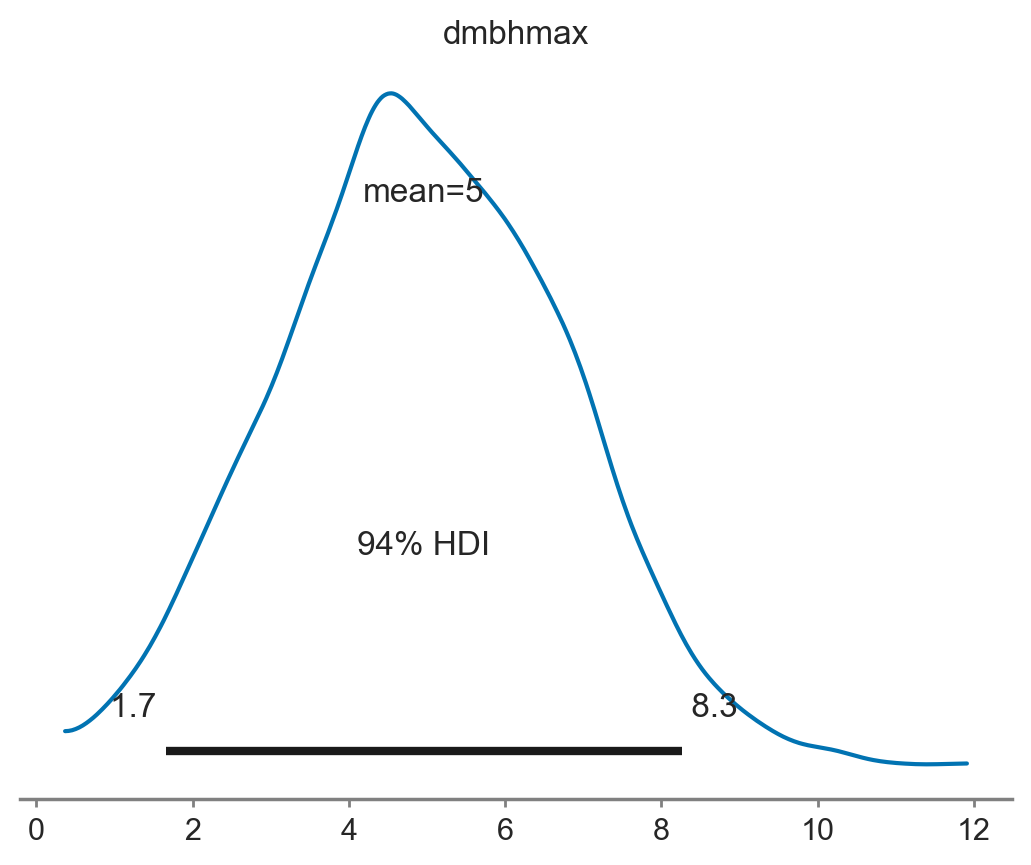

In [33]:
az.plot_posterior(trace, var_names=['dmbhmax'])

<Axes: ylabel='Density'>

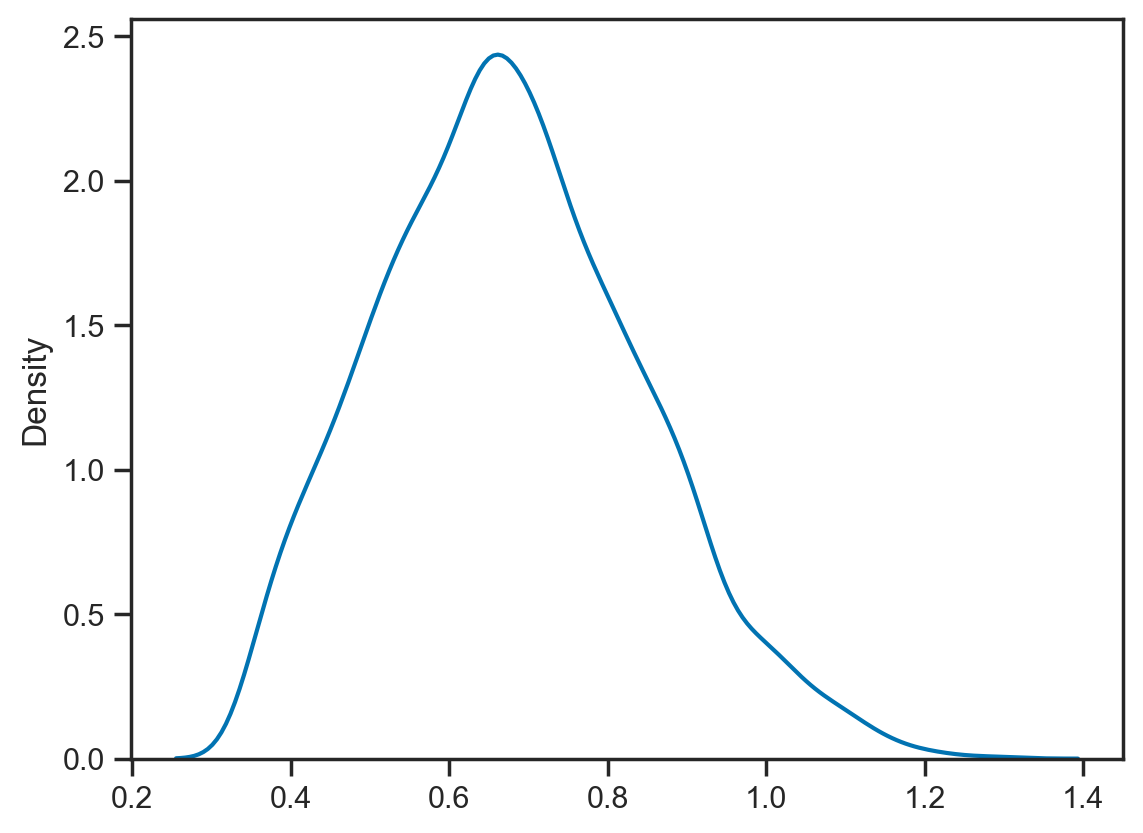

In [34]:
sns.kdeplot(trace_cosmo.posterior.h.values.flatten())

<Axes: ylabel='Density'>

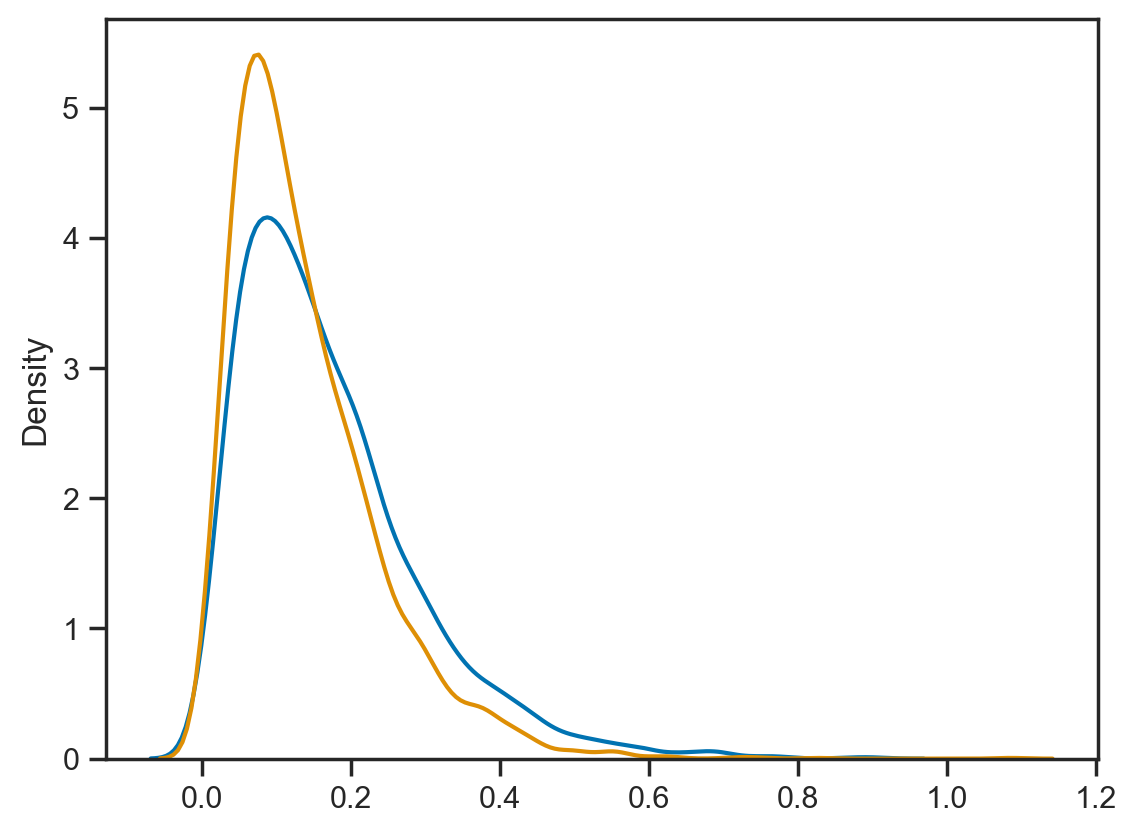

In [38]:
hp = []
Om = []
while len(hp) < 4000:
    h = np.random.normal(loc=0.7, scale=0.2)
    O = np.random.normal(loc=0.3, scale=0.15)

    if h < 0.35 or h > 1.4 or O < 0 or O > 1:
        continue
    hp.append(h)
    Om.append(O)
hp = np.array(hp)
Om = np.array(Om)
omh2 = Om*np.square(hp)

sns.kdeplot(omh2)
trace_cosmo.posterior["Omh2"] = trace_cosmo.posterior.Om * np.square(trace_cosmo.posterior.h)
sns.kdeplot(trace_cosmo.posterior.Omh2.values.flatten())

In [39]:
trace_cosmo.posterior.h.std()

<xarray.DataArray 'h' ()>
array(0.16602511)

In [40]:
np.std(hp)

0.18194489282304724

In [41]:
trace_cosmo.posterior.Omh2.std()

<xarray.DataArray 'Omh2' ()>
array(0.09869196)

In [43]:
np.std(omh2)

0.12102092163543657

In [44]:
np.random.SeedSequence().entropy

19465866273830024359462994947182329018